In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' ## Change to empty GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [4]:
from functools import partial
import jax
from jax import random, grad, jit, vmap, flatten_util, nn
from jax.experimental import optix
from jax.config import config
import jax.numpy as np

import haiku as hk
from haiku._src import utils

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import cv2
import imageio
import glob
from IPython.display import clear_output
import pickle
from skimage.metrics import structural_similarity as ssim_fn

rng = jax.random.PRNGKey(42)

# Load Data

In [21]:
DATASET = 'sacre'
posedir = f'/data/phototourism/ours/sacre/' # Directory condtains [bds.npy, c2w_mats.npy, kinv_mats.npy, res_mats.npy]
imgdir = f'/data/phototourism/sacre/sacre_coeur/dense/images/' # Directory of images

posedata = {}
for f in os.listdir(posedir):
    if '.npy' not in f:
        continue
    z = np.load(os.path.join(posedir, f))
    posedata[f.split('.')[0]] = z
print('Pose data loaded - ', posedata.keys())

imgfiles = sorted(glob.glob(imgdir + '/*.jpg'))
print(f'{len(imgfiles)} images')

Pose data loaded -  dict_keys(['bds', 'kinv_mats', 'c2w_mats', 'res_mats'])
1179 images


In [19]:
def get_example(img_idx, split='train', downsample=4):
    sc = .05
    if 'train' in split:
        img_idx += 25
    if 'val' in split:
        img_idx += 20
    img = imageio.imread(imgfiles[img_idx])[...,:3]/255.
    c2w = posedata['c2w_mats'][img_idx]
    kinv = posedata['kinv_mats'][img_idx]
    c2w = np.concatenate([c2w[:3,:3], c2w[:3,3:4]*sc], -1)
    bds = posedata['bds'][img_idx] * np.array([.9, 1.2]) * sc
    H, W = img.shape[:2]
    i, j = np.meshgrid(np.arange(0,W,downsample), np.arange(0,H,downsample), indexing='xy')
    
    test_images = img[j, i]
    test_rays = get_rays(c2w, kinv, i, j)
    return test_images, test_rays, bds

# NeRF Renderer and Model

In [12]:
def render_rays(rnd_input, model, params, bvals, rays, near, far, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(rnd_input, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = np.reshape(pts, [-1,3])
    if bvals is not None:
        pts_flat = np.concatenate([np.sin(pts_flat @ bvals.T), 
                                np.cos(pts_flat @ bvals.T)], axis=-1)
        
    raw = model.apply(params, pts_flat)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1. - np.exp(-sigma_a * dists)
    trans = np.minimum(1., 1. - alpha + 1e-10)
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2) 
    acc_map = np.sum(weights, -1)
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = np.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(rnd_input, model, params, bvals, rays, near, far, rand, allret, N_samples):
    return render_rays(rnd_input, model, params, bvals, rays, near, far, N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(1, 7, 8, 9))

def render_fn(rnd_input, model, params, bvals, rays, near, far, N_samples, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(rnd_input, model, params, bvals, rays[:,i:i+chunk], near, far, rand, True, N_samples)
        if i==0:
            rets = out
        else:
            rets = [np.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets

In [13]:
class Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.width = 256
        self.depth = 6
        self.use_viewdirs = False
                
    def __call__(self, coords, view_dirs=None):
        sh = coords.shape
        if self.use_viewdirs:
            viewdirs = None
            viewdirs = np.repeat(viewdirs[...,None,:], coords.shape[-2], axis=-2)
            viewdirs /= np.linalg.norm(viewdirs, axis=-1, keepdims=True)
            viewdirs = np.reshape(viewdirs, (-1,3))
            viewdirs = hk.Linear(output_size=self.width//2)(viewdirs)
            viewdirs = jax.nn.relu(viewdirs)
        coords = np.reshape(coords, [-1,3])
        
        x = np.concatenate([np.concatenate([np.sin(coords*(2**i)), np.cos(coords*(2**i))], axis=-1) for i in np.linspace(0,8,20)], axis=-1)

        for _ in range(self.depth-1):
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            
        if self.use_viewdirs:
            density = hk.Linear(output_size=1)(x)
            x = np.concatenate([x,viewdirs], axis=-1)
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            rgb = hk.Linear(output_size=3)(x)
            out = np.concatenate([density, rgb], axis=-1)
        else:
            out = hk.Linear(output_size=4)(x)
        out = np.reshape(out, list(sh[:-1]) + [4])
        return out

In [14]:
@jit
def get_rays(c2w, kinv, i, j):
#     i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    pixco = np.stack([i, j, np.ones_like(i)], -1)
    dirs = pixco @ kinv.T
#     dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

def normalize(x):
    return x / np.linalg.norm(x)
def viewmatrix(z, up, pos):
    vec2 = normalize(z)
    vec1_avg = up
    vec0 = normalize(np.cross(vec1_avg, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, pos], 1)
    return m
def ptstocam(pts, c2w):
    tt = np.matmul(c2w[:3,:3].T, (pts-c2w[:3,3])[...,np.newaxis])[...,0]
    return tt
def poses_avg(poses):
    center = poses[:, :3, 3].mean(0)
    vec2 = normalize(poses[:, :3, 2].sum(0))
    up = poses[:, :3, 1].sum(0)
    return viewmatrix(vec2, up, center)
def render_path_spiral(c2w, up, rads, focal, zrate, rots, N):
    render_poses = []
    rads = np.array(list(rads) + [1.])
    for theta in np.linspace(0., 2. * np.pi * rots, N+1)[:-1]:
        c = np.dot(c2w[:3,:4], np.array([np.cos(theta), -np.sin(theta), -np.sin(theta*zrate), 1.]) * rads) 
        z = normalize(c - np.dot(c2w[:3,:4], np.array([0,0,-focal, 1.])))
        render_poses.append(viewmatrix(z, up, c))
    return render_poses


In [15]:
batch_size = 64
N_samples = 128
inner_step_size = 1

model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

@jit
def single_step(rng, image, rays, params, bds):
    def sgd(param, update):
        return param - inner_step_size * update
    
    rng, rng_inputs = jax.random.split(rng)
    def loss_model(params):
        g = render_rays(rng_inputs, model, params, None, rays, bds[0], bds[1], N_samples, rand=True)
        return mse_fn(g, image)
    
    model_loss, grad = jax.value_and_grad(loss_model)(params)
    new_params = jax.tree_multimap(sgd, params, grad)
    return rng, new_params, model_loss

def update_network_weights(rng, images, rays, params, inner_steps, bds):
    for _ in range(inner_steps):
        rng, rng_input = random.split(rng)
        idx = random.randint(rng_input, shape=(batch_size,), minval=0, maxval=images.shape[0])
        image_sub = images[idx,:]
        rays_sub = rays[:,idx,:]
        
        rng, params, loss = single_step(rng, image_sub, rays_sub, params, bds)
    return rng, params, loss

# Meta Train

In [17]:
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

In [ ]:
max_iters = 150000

inner_update_steps = 64
lr = 5e-4

exp_name = f'{DATASET}_ius_{inner_update_steps}_ilr_{inner_step_size}_olr_{lr}_bs_{batch_size}'
exp_dir = f'checkpoint/phototourism_checkpoints/{exp_name}/'

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

params = model.init(rng, np.ones((1,3)))

opt = optix.adam(lr)
opt_state = opt.init(params)

test_inner_steps = 64


def update_model(rng, params, opt_state, image, rays, bds):
    rng, new_params, model_loss = update_network_weights(rng, image, rays, params, inner_update_steps, bds)
    
    def calc_grad(params, new_params):
        return params - new_params
    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss

@jit
def update_model_single(rng, params, opt_state, image, rays, bds):
    rng, new_params, model_loss = single_step(rng, image, rays, params, bds)
    
    def calc_grad(params, new_params):
        return params - new_params
    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss



plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')
step = 0

train_psnrs = []
rng = jax.random.PRNGKey(0)

train_steps = []
train_psnrs_all = []
test_steps = []
test_psnrs_all = []
for step in tqdm(range(max_iters)):
    try:
        rng, rng_input = jax.random.split(rng)
        img_idx = random.randint(rng_input, shape=(), minval=0, maxval=len(imgfiles)-25)        
        images, rays, bds = get_example(img_idx, downsample=1)
    except:
        print('data loading error')
        raise
        continue
        

    images = np.reshape(images, (-1,3))
    rays = np.reshape(rays, (2,-1,3))

    if inner_update_steps == 1:
        rng, rng_input = random.split(rng)
        idx = random.randint(rng_input, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, opt_state, loss = update_model_single(rng, params, opt_state, images[idx,:], rays[:,idx,:], bds)
    else:
        rng, params, opt_state, loss = update_model(rng, params, opt_state, images, rays, bds)
    train_psnrs.append(-10 * np.log10(loss))

    if step % 250 == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_steps.append(step)
        train_psnrs_all.append(np.mean(np.array(train_psnrs)))
        train_psnrs = []
    if step % 500 == 0 and step != 0:
        test_psnr = []
        for ti in range(5):
            test_images, test_rays, bds = get_example(ti, split='val', downsample=2)

            test_images, test_holdout_images = np.split(test_images, [test_images.shape[1]//2], axis=1)
            test_rays, test_holdout_rays = np.split(test_rays, [test_rays.shape[2]//2], axis=2)

            test_images_flat = np.reshape(test_images, (-1,3))
            test_rays = np.reshape(test_rays, (2,-1,3))

            rng, test_params, test_inner_loss = update_network_weights(rng, test_images_flat, test_rays, params, test_inner_steps, bds)

            test_result = np.clip(render_fn(rng, model, test_params, None, test_holdout_rays, bds[0], bds[1], N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_holdout_images, test_result))
        test_psnr = np.mean(np.array(test_psnr))

        test_steps.append(step)
        test_psnrs_all.append(test_psnr)
        
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15,5))   
        plt.subplot(1,3, 1)
        plt.imshow(test_images)
        plt.subplot(1,3, 2)
        plt.imshow(test_holdout_images)
        plt.subplot(1,3, 3)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        test_images, test_rays, bds = get_example(0, split='test')
        test_images_flat = np.reshape(test_images, (-1,3))
        test_rays = np.reshape(test_rays, (2,-1,3))
        rng, test_params_1, test_inner_loss = update_network_weights(rng, test_images_flat, test_rays, params, test_inner_steps, bds)

        test_images, test_rays, bds = get_example(1, split='test')
        test_images_flat = np.reshape(test_images, (-1,3))
        test_rays = np.reshape(test_rays, (2,-1,3))
        rng, test_params_2, test_inner_loss = update_network_weights(rng, test_images_flat, test_rays, params, test_inner_steps, bds)
        
        poses = posedata['c2w_mats']
        c2w = poses_avg(poses)
        focal = .8
        render_poses = render_path_spiral(c2w, c2w[:3,1], [.1, .1, .05], focal, zrate=.5, rots=2, N=120)
        
        bds = np.array([5., 25.]) * .05
        H = 128
        W = H*3//2
        f = H * 1.
        kinv = np.array([
            1./f, 0, -W*.5/f,
            0, -1./f, H*.5/f,
            0, 0, -1.
        ]).reshape([3,3])
        i, j = np.meshgrid(np.arange(0,W), np.arange(0,H), indexing='xy')
        renders = []
        for p, c2w in enumerate(tqdm(render_poses)):
            rays = get_rays(c2w, kinv, i, j)
            interp = p / len(render_poses)
            interp_params = jax.tree_multimap(lambda x, y: y*p/len(render_poses) + x*(1-p/len(render_poses)), test_params_1, test_params_2)
            result = render_fn(rng, model, interp_params, None, rays, bds[0], bds[1], N_samples, rand=False)[0]
            renders.append(result)
        
        renders = (np.clip(np.array(renders), 0, 1)*255).astype(np.uint8)
        imageio.mimwrite(f'{exp_dir}render_sprial_{step}.mp4', renders, fps=30, quality=8)
        
        plt.plot(train_steps, train_psnrs_all)
        plt.savefig(f'{exp_dir}train_curve_{step}.png')
        
        plt.plot(test_steps, test_psnrs_all)
        plt.savefig(f'{exp_dir}test_curve_{step}.png')
        
        with open(f'{exp_dir}checkpount_{step}.pkl', 'wb') as file:
            pickle.dump(params, file)

# Test-time optimization

### Load checkpoint (optional)

In [23]:
checkpoint_file = 'checkpoint/phototourism_checkpoints/sacre_checkpount_150000.pkl'

with open(checkpoint_file, 'rb') as file:
    params = pickle.load(file)

### Render Grid

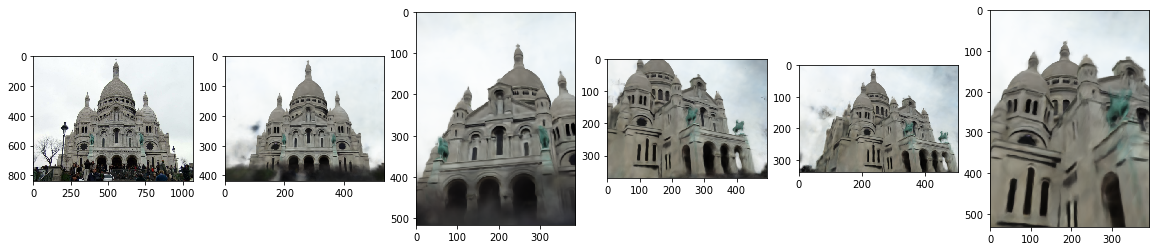

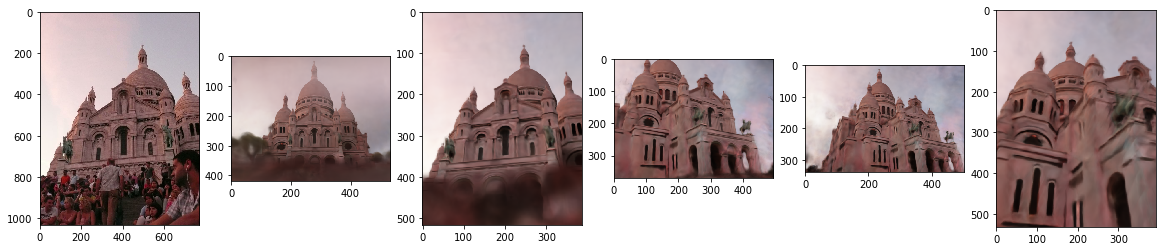

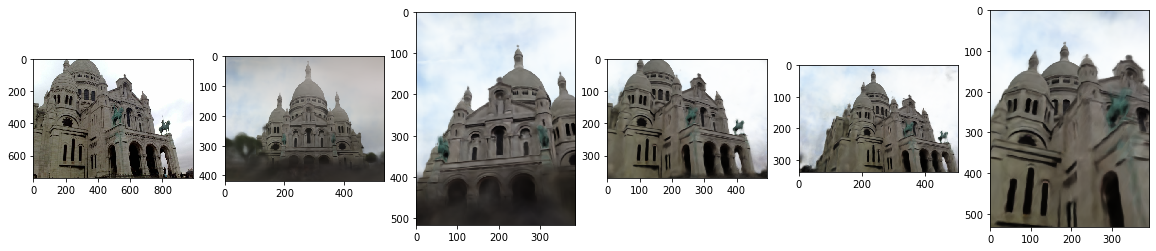

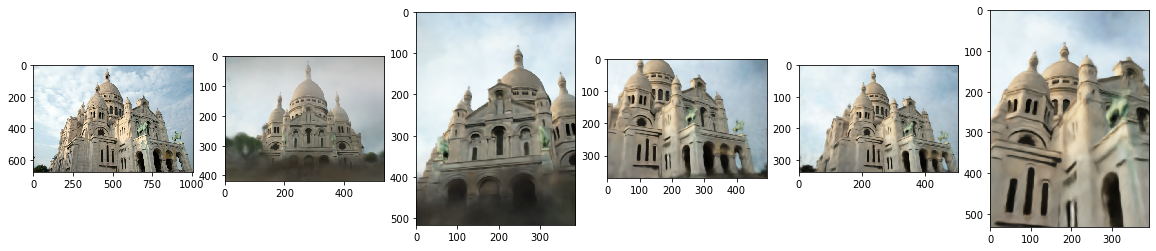

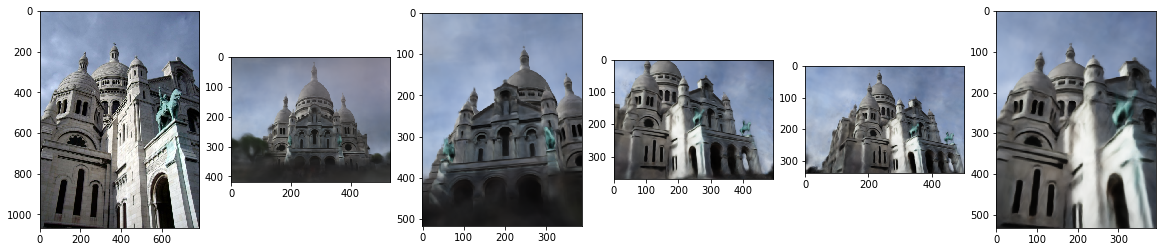

In [24]:
downsample = 2
ius = 256

if 'trevi' in DATASET:
    views = [0,2,14,6,9]
if 'sacre' in DATASET:
    views = [5,3,9,10,12]
if 'bandenburg' in DATASET:
    views = [0,6,8,7,13]

for i in views:
    plt.figure(figsize=(20,5)) 
    test_images, test_rays, bds = get_example(i, downsample=1)
    test_images_flat = np.reshape(test_images, (-1,3))
    test_rays = np.reshape(test_rays, (2,-1,3))
    rng, test_params, test_inner_loss = update_network_weights(rng, test_images_flat, test_rays, params, ius, bds)
    plt.subplot(1,6, 1)
    plt.imshow(test_images)
    
    for j, p in enumerate(views):
        test_holdout_image, test_holdout_rays, test_bds = get_example(p, downsample=downsample)
        test_result = np.clip(render_fn(rng, model, test_params, None, test_holdout_rays, test_bds[0], test_bds[1], N_samples, rand=False)[0], 0, 1)
    
        plt.subplot(1,6, j+2)
        plt.imshow(test_result)
    plt.show()